In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd


In [2]:
climate_data = pd.read_parquet("data/climate_clean.parquet")
barley_data = pd.read_csv("data/barley_yield_from_1982.csv", delimiter=";", index_col=0).reset_index()

In [3]:
climate_data.head()

,scenario,nom_dep,code_dep,time,year,metric,value
0,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,3.142273
1,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,1.942413
2,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,3.268524
3,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,5.743378
4,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,5.737213


# Analyse Exploratoire

## Climat

In [4]:
hist_data = climate_data[climate_data["scenario"] == "historical"]
future_data = climate_data[climate_data["scenario"] != "historical"]

hist_temps = hist_data[hist_data["metric"]=="near_surface_air_temperature"]

# Mean and std per department-year
hist_year_dep = (
    hist_temps.groupby(["year","code_dep"])["value"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "mean_temp_C", "std": "std_temp_C"})
)

# Mean and std across departments (national)
hist_year_nat = (
    hist_year_dep.groupby("year")["mean_temp_C"]
    .agg(["mean", "std"])
    .reset_index()
    .rename(columns={"mean": "mean_temp_C", "std": "std_temp_C"})
)

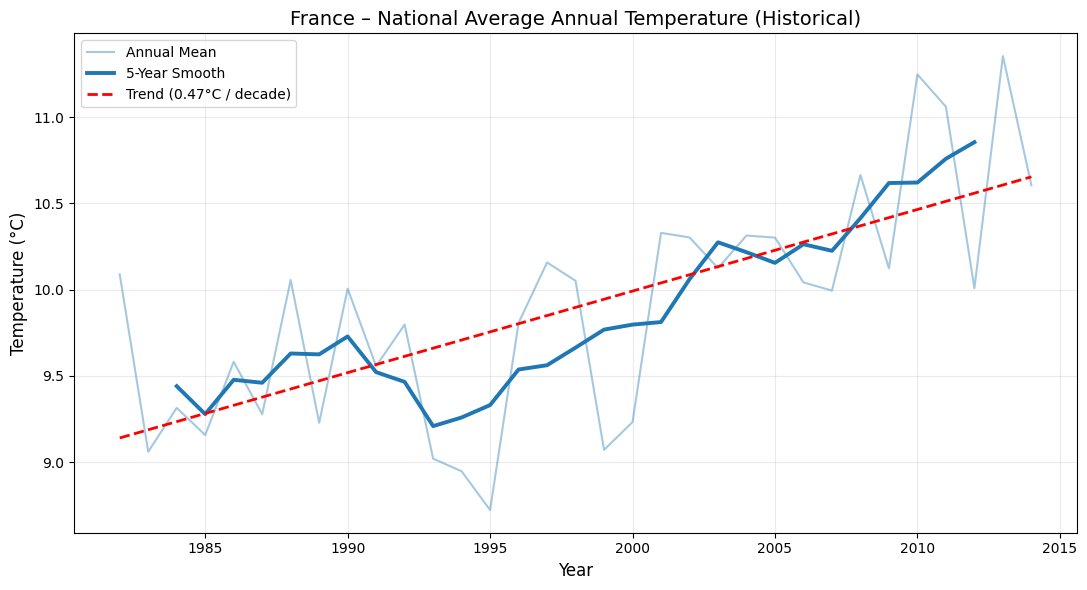

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

df = hist_year_nat.copy()

# --- Optional smoothing (5-year rolling mean) ---
df["smooth"] = df["mean_temp_C"].rolling(window=5, center=True).mean()

# --- Linear trend (°C / year) ---
X = df["year"].values.reshape(-1, 1)
y = df["mean_temp_C"].values
model = LinearRegression().fit(X, y)

trend = model.predict(X)
rate_per_decade = model.coef_[0] * 10  # °C per decade

# --- Plot ---
plt.figure(figsize=(11,6))
plt.plot(df["year"], df["mean_temp_C"], color="#1f77b4", alpha=0.4, linewidth=1.5, label="Annual Mean")
plt.plot(df["year"], df["smooth"], color="#1f77b4", linewidth=2.8, label="5-Year Smooth")
plt.plot(df["year"], trend, "--", color="red", linewidth=2, label=f"Trend ({rate_per_decade:.2f}°C / decade)")

# Style improvements
plt.title("France – National Average Annual Temperature (Historical)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.grid(alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import numpy as np

# Only temperature
temp = climate_data[climate_data["metric"]=="near_surface_air_temperature"].copy()

# Ensure correct types
temp["value"] = pd.to_numeric(temp["value"], errors="coerce")
temp = temp.replace([np.inf, -np.inf], np.nan).dropna(subset=["value"])
temp["year"] = temp["year"].astype(int)
temp["date"] = temp["time"].dt.date

# Daily mean per department
temp_daily = temp.groupby(["scenario","date","code_dep"])["value"].mean().reset_index()

# Yearly mean per department
temp_year_dep = (
    temp_daily.assign(year=lambda x: pd.to_datetime(x["date"]).dt.year)
              .groupby(["scenario","year","code_dep"])["value"]
              .mean()
              .reset_index()
)

# National annual temperature
temp_year_nat = (
    temp_year_dep.groupby(["scenario","year"])["value"]
                 .mean()
                 .reset_index()
                 .rename(columns={"value":"mean_temp_C"})
)


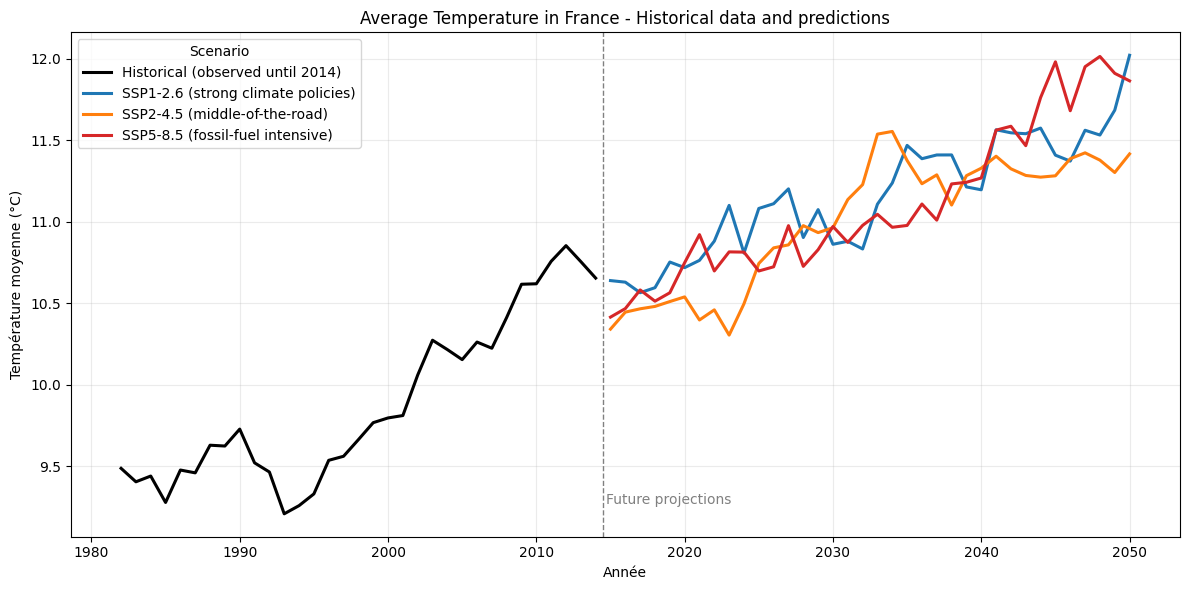

In [7]:
import matplotlib.pyplot as plt

scenarios = {
    "historical": "black",
    "ssp1_2_6": "#1f77b4",
    "ssp2_4_5": "#ff7f0e",
    "ssp5_8_5": "#d62728"
}
legend_labels = {
    "historical": "Historical (observed until 2014)",
    "ssp1_2_6": "SSP1-2.6 (strong climate policies)",
    "ssp2_4_5": "SSP2-4.5 (middle-of-the-road)",
    "ssp5_8_5": "SSP5-8.5 (fossil-fuel intensive)"
}


plt.figure(figsize=(12,6))

for scen, color in scenarios.items():
    df = temp_year_nat[temp_year_nat["scenario"] == scen].copy()
    df["smooth"] = df["mean_temp_C"].rolling(window=5, min_periods=1, center=True).mean()
    plt.plot(df["year"], df["smooth"], label=legend_labels[scen], linewidth=2.2, color=color)

# historical/projection separator
plt.axvline(2014.5, color="grey", linestyle="--", linewidth=1)
plt.text(2014.7, plt.ylim()[0]+0.2, "Future projections", color="grey")

plt.title("Average Temperature in France - Historical data and predictions")
plt.xlabel("Année")
plt.ylabel("Température moyenne (°C)")
plt.grid(alpha=0.25)
plt.legend(title="Scenario")
plt.tight_layout()
plt.show()


In [8]:
# Filter temperature only
temp = climate_data[climate_data["metric"]=="near_surface_air_temperature"].copy()
temp["year"] = temp["year"].astype(int)

# Historical baseline (1980-2014)
hist_baseline = (
    temp[(temp["scenario"]=="historical") & (temp["year"] >= 1980) & (temp["year"] <= 2014)]
    .groupby("code_dep")["value"]
    .mean()
    .reset_index()
    .rename(columns={"value": "hist_avg_temp"})
)
future_mid = (
    temp[(temp["scenario"] != "historical") & (temp["year"] >= 2035) & (temp["year"] <= 2050)]
    .groupby(["scenario", "code_dep"])["value"]
    .mean()
    .reset_index()
    .rename(columns={"value": "mid_future_temp"})
)

warming = future_mid.merge(hist_baseline, on="code_dep")
warming["warming_C"] = warming["mid_future_temp"] - warming["hist_avg_temp"]



In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression

trends = []

for scen in temp["scenario"].unique():
    if scen == "historical":
        continue

    df_s = temp[temp["scenario"] == scen].copy()
    
    for dep in df_s["code_dep"].unique():
        df_d = df_s[df_s["code_dep"] == dep]
        X = df_d["year"].values.reshape(-1, 1)
        y = df_d["value"].values
        
        if len(X) > 5:  # avoid missing data artifacts
            model = LinearRegression().fit(X, y)
            trend = model.coef_[0] * 10  # °C per decade
            
            trends.append({"scenario": scen, "code_dep": dep, "warming_rate_C_decade": trend})

trend_map = pd.DataFrame(trends)

In [10]:
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_FRA_2.json"
france_deps = gpd.read_file(url)
france_deps["code_dep"] = france_deps["CC_2"].str[-2:]
warming_map = france_deps.merge(trend_map, on="code_dep", how="left")


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'geodata.ucdavis.edu'. (_ssl.c:1147)>

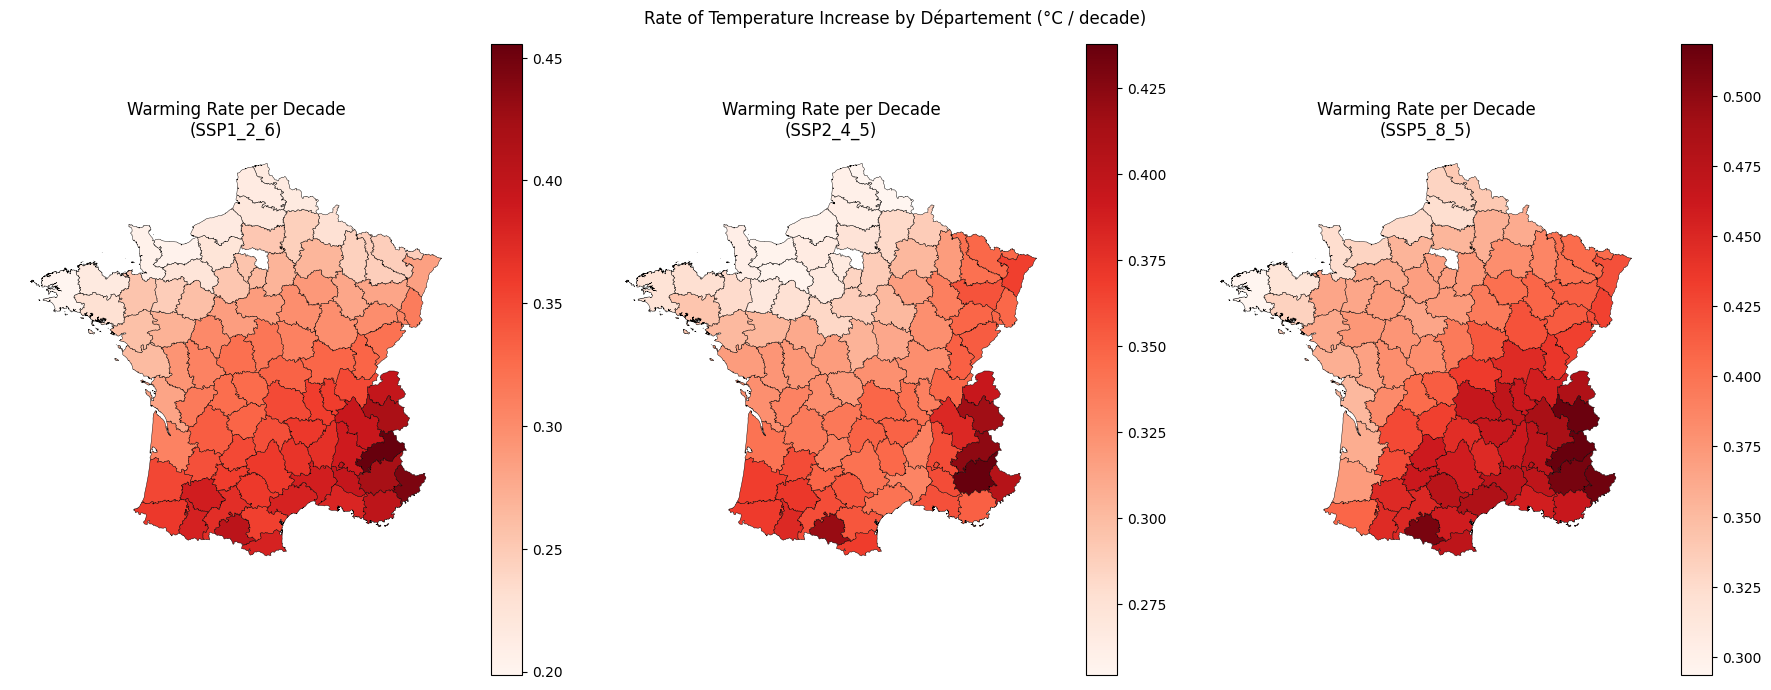

In [ ]:
import matplotlib.pyplot as plt

scenarios = ["ssp1_2_6", "ssp2_4_5", "ssp5_8_5"]

fig, axes = plt.subplots(1, 3, figsize=(18, 7))

for ax, scen in zip(axes, scenarios):
    gdf = warming_map[warming_map["scenario"] == scen]
    gdf.plot(
        column="warming_rate_C_decade",
        cmap="Reds",
        linewidth=0.3,
        edgecolor="black",
        legend=True,
        ax=ax,
        missing_kwds=dict(color="lightgrey"),
    )
    ax.set_title(f"Warming Rate per Decade\n({scen.upper()})")
    ax.axis("off")

plt.suptitle("Rate of Temperature Increase by Département (°C / decade)")
plt.tight_layout()
plt.show()


## Barley Yield

In [ ]:
dep_map = (
    climate_data[["nom_dep", "code_dep"]]
    .drop_duplicates()
    .set_index("nom_dep")["code_dep"]
    .to_dict()
)

barley_data["code_dep"] = barley_data["department"].map(dep_map)
barley_data["year"] = barley_data["year"].astype(int)

# Compute yield if missing but we have area & production
mask = barley_data["yield"].isna() & barley_data["production"].notna() & barley_data["area"].notna()

barley_data.loc[mask, "yield"] = barley_data.loc[mask, "production"] / barley_data.loc[mask, "area"]

barley_data = barley_data[~(barley_data["yield"].isna())]

# If production is missing but yield and area exist → compute it
mask_prod = barley_data["production"].isna() & barley_data["yield"].notna() & barley_data["area"].notna()
barley_data.loc[mask_prod, "production"] = barley_data.loc[mask_prod, "yield"] * barley_data.loc[mask_prod, "area"]


In [ ]:
import pandas as pd

barley = barley_data.copy()
barley["year"] = barley["year"].astype(int)

# Define periods
periods = {
    "1980 - 1995": (1980, 1995),
    "1996 - 2005": (1996, 2005),
    "2006 - 2015": (2006, 2015)
}

period_list = []

for label, (start, end) in periods.items():
    df_p = barley[(barley["year"] >= start) & (barley["year"] <= end)]
    df_group = (
        df_p.groupby("code_dep")["yield"]
            .mean()
            .reset_index()
            .rename(columns={"yield": "yield_t_ha"})
    )
    df_group["period"] = label
    period_list.append(df_group)

barley_periods = pd.concat(period_list, ignore_index=True)

# Pivot so we can compute change
wide = barley_periods.pivot(index="code_dep", columns="period", values="yield_t_ha")

# Compute % change: 2006–2015 vs 1980–1995
wide["%_change"] = (wide["2006 - 2015"] - wide["1980 - 1995"]) / wide["1980 - 1995"] * 100

wide = wide.reset_index()

barley_map_all = france_deps.merge(wide, on="code_dep", how="left")

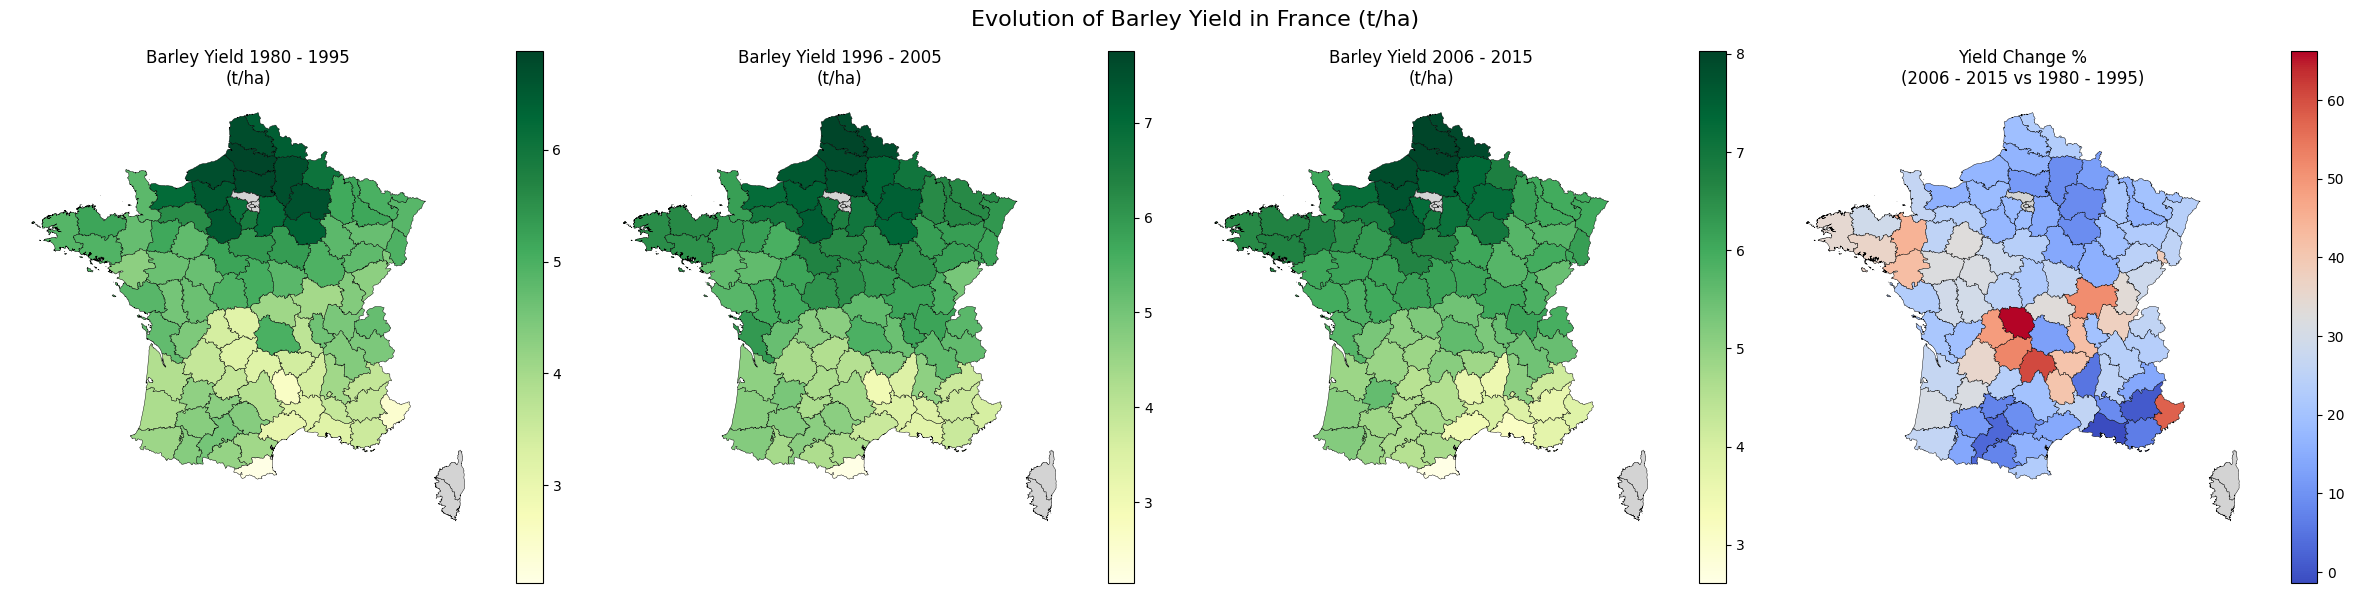

: 

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

cmap = "YlGn"

for ax, label in zip(axes[:3], periods.keys()):
    barley_map_all.plot(
        column=label,
        cmap=cmap,
        linewidth=0.3,
        edgecolor="black",
        legend=True,
        ax=ax,
        missing_kwds=dict(color="lightgrey", label="No data")
    )
    ax.set_title(f"Barley Yield {label}\n(t/ha)")
    ax.axis("off")

# Change map
barley_map_all.plot(
    column="%_change",
    cmap="coolwarm",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    ax=axes[3],
    missing_kwds=dict(color="lightgrey", label="No data")
)
axes[3].set_title("Yield Change %\n(2006 - 2015 vs 1980 - 1995)")
axes[3].axis("off")

plt.suptitle("Evolution of Barley Yield in France (t/ha)", fontsize=16)
plt.tight_layout()
plt.show()


# Data Prediction

In [12]:
df

,scenario,nom_dep,code_dep,time,year,metric,value,date,month
0,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,3.142273,1982-01-01,1
1,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,1.942413,1982-01-02,1
2,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,3.268524,1982-01-03,1
3,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,5.743378,1982-01-04,1
4,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,5.737213,1982-01-05,1
...,...,...,...,...,...,...,...,...,...
13527327,ssp5_8_5,Yvelines,78,2015-12-27 12:00:00,2015,precipitation,0.008156,2015-12-27,12
13527328,ssp5_8_5,Yvelines,78,2015-12-28 12:00:00,2015,precipitation,0.182694,2015-12-28,12
13527329,ssp5_8_5,Yvelines,78,2015-12-29 12:00:00,2015,precipitation,0.037260,2015-12-29,12
13527330,ssp5_8_5,Yvelines,78,2015-12-30 12:00:00,2015,precipitation,0.000000,2015-12-30,12


In [ ]:
import pandas as pd
import numpy as np

df = climate_data.copy()
df["year"] = df["year"].astype(int)

# ⚠️ Limit to years we have yield data for:
df = df[df["year"] <= 2015]
df["date"] = df["time"].dt.date
df["month"] = df["time"].dt.month


# === SELECTOR ===
def seasonal(df, months):
    return df[df["month"].isin(months)]

# === TEMPERATURE MEAN ===
tmean = df[df["metric"] == "near_surface_air_temperature"]

# === TEMPERATURE MAX ===
tmax = df[df["metric"] == "daily_maximum_near_surface_air_temperature"]

# ======================================================================================
#  GDD (Growing Degree Days) → early biomass (Feb–Apr)
# ======================================================================================
gdd = seasonal(tmean, [2,3,4]).copy()
gdd["GDD"] = np.maximum(0, gdd["value"] - 5)  # T_base = 5°C for barley
gdd = gdd.groupby(["scenario","code_dep","year"])["GDD"].sum().reset_index()

# ======================================================================================
#  Heat Stress (May–Jul) → shrinks grains (hot28, hot32)
# ======================================================================================
heat = seasonal(tmax, [5,6,7]).copy()
heat["hot28"] = heat["value"] > 28
heat["hot32"] = heat["value"] > 32
heat = heat.groupby(["scenario","code_dep","year"])[["hot28","hot32"]].sum().reset_index()

# ======================================================================================
# Cold Stress (Apr–May) → risk for heading & flowers
# ======================================================================================
cold = seasonal(tmean, [4,5]).copy()
cold["cold2"] = cold["value"] < 2
cold = cold.groupby(["scenario","code_dep","year"])["cold2"].sum().reset_index()

# ======================================================================================
# Spring Rain (Mar–May) → tillering + biomass formation
# ======================================================================================
rain = df[df["metric"] == "precipitation"]
rain_spring = seasonal(rain, [3,4,5])
rain_spring = rain_spring.groupby(["scenario","code_dep","year"])["value"].sum().reset_index()
rain_spring = rain_spring.rename(columns={"value": "spring_rain_mm"})

# ======================================================================================
# Drought Index (May–Jun) → water stress during grain fill
# ======================================================================================
drought = seasonal(rain, [5,6]).copy()
tmax_mj = seasonal(tmax, [5,6])[["scenario","code_dep","year","value"]].rename(columns={"value":"tmax"})
drought = drought.merge(tmax_mj, on=["scenario","code_dep","year","date"])
drought["drought"] = drought["value"] - 0.25 * drought["tmax"]  # α=0.25 empirical
drought = drought.groupby(["scenario","code_dep","year"])["drought"].sum().reset_index()

# ======================================================================================
# FINAL TABLE
# ======================================================================================
climate_indicators = gdd.merge(heat, on=["scenario","code_dep","year"]) \
                        .merge(cold, on=["scenario","code_dep","year"]) \
                        .merge(rain_spring, on=["scenario","code_dep","year"]) \
                        .merge(drought, on=["scenario","code_dep","year"])

climate_indicators.head()


KeyError: 'date'

In [22]:
drought

,scenario,nom_dep,code_dep,time,year,metric,value,date,month
2145554,historical,Ain,01,1982-05-01 12:00:00,1982,precipitation,0.181415,1982-05-01,5
2145555,historical,Ain,01,1982-05-02 12:00:00,1982,precipitation,0.098482,1982-05-02,5
2145556,historical,Ain,01,1982-05-03 12:00:00,1982,precipitation,0.324058,1982-05-03,5
2145557,historical,Ain,01,1982-05-04 12:00:00,1982,precipitation,0.035296,1982-05-04,5
2145558,historical,Ain,01,1982-05-05 12:00:00,1982,precipitation,0.291877,1982-05-05,5
...,...,...,...,...,...,...,...,...,...
13527143,ssp5_8_5,Yvelines,78,2015-06-26 12:00:00,2015,precipitation,0.016845,2015-06-26,6
13527144,ssp5_8_5,Yvelines,78,2015-06-27 12:00:00,2015,precipitation,0.041062,2015-06-27,6
13527145,ssp5_8_5,Yvelines,78,2015-06-28 12:00:00,2015,precipitation,0.036984,2015-06-28,6
13527146,ssp5_8_5,Yvelines,78,2015-06-29 12:00:00,2015,precipitation,0.005152,2015-06-29,6
